In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


In [3]:
# sempre usaremos o CSV local para evitar falhas da API
df = pd.read_csv('data/btc_limpo.csv')

# garantir colunas corretas
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']].dropna().sort_values('Date').reset_index(drop=True)

print('Período:', df['Date'].min(), '->', df['Date'].max())
df.tail()


Período: 2020-06-01 00:00:00 -> 2025-05-31 00:00:00


,Date,Close
1821,2025-05-27,108994.640625
1822,2025-05-28,107802.328125
1823,2025-05-29,105641.757812
1824,2025-05-30,103998.570312
1825,2025-05-31,104638.093750


In [4]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# normalização
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df[['Close']])

SEQ_LEN = 60
X, y = create_sequences(scaled, SEQ_LEN)

# dividir em treino/teste (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# reshape para LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Treino:", X_train.shape, "Teste:", X_test.shape)


Treino: (1412, 60, 1) Teste: (354, 60, 1)


In [5]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [6]:
def build_and_train(units=50, epochs=20, batch_size=32, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, return_sequences=False, input_shape=(SEQ_LEN,1)))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), verbose=0)
    
    # previsão
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds)
    y_true = scaler.inverse_transform(y_test.reshape(-1,1))

    # calcular MAPE
    score = mape(y_true, preds)

    return model, preds, y_true, score, history


In [7]:
configs = [
    {'units':50, 'epochs':20, 'batch_size':32},
    {'units':100, 'epochs':20, 'batch_size':32},
    {'units':50, 'epochs':40, 'batch_size':32},
    {'units':50, 'epochs':20, 'batch_size':64},
]

results = []
for cfg in configs:
    model, preds, y_true, score, history = build_and_train(**cfg)
    results.append((cfg, score))
    print(f"Config {cfg} -> MAPE = {score:.2f}%")


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step 
Config {'units': 50, 'epochs': 20, 'batch_size': 32} -> MAPE = 3.29%


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step 
Config {'units': 100, 'epochs': 20, 'batch_size': 32} -> MAPE = 2.67%


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
Config {'units': 50, 'epochs': 40, 'batch_size': 32} -> MAPE = 2.24%


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 
Config {'units': 50, 'epochs': 20, 'batch_size': 64} -> MAPE = 3.19%



Melhor configuração: {'units': 50, 'epochs': 40, 'batch_size': 32} -> MAPE: 2.24 %


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step 


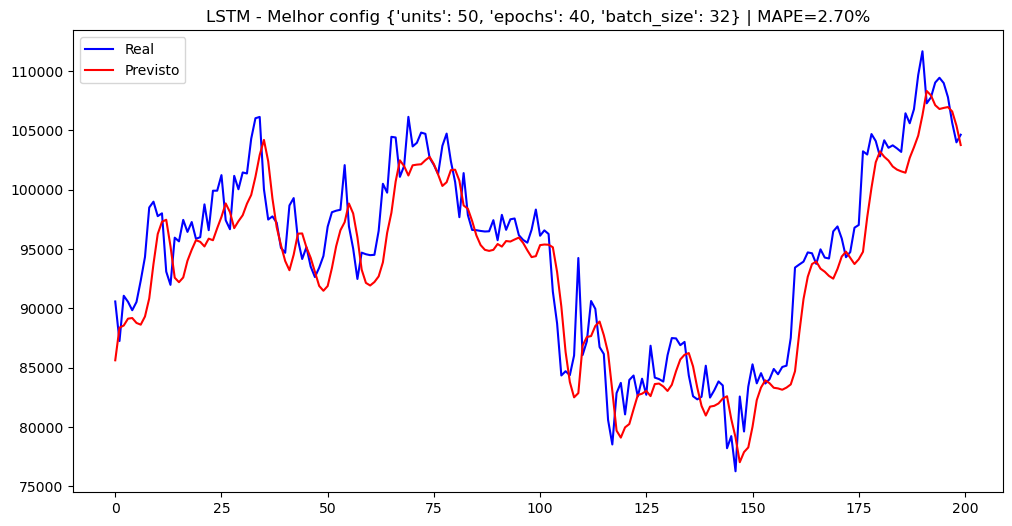

In [8]:
# pegar melhor config
best_cfg, best_score = min(results, key=lambda x: x[1])
print("\nMelhor configuração:", best_cfg, "-> MAPE:", round(best_score,2), "%")

# re-treinar modelo melhor
model, preds, y_true, score, history = build_and_train(**best_cfg)

plt.figure(figsize=(12,6))
plt.plot(y_true[-200:], label='Real', color='blue')
plt.plot(preds[-200:], label='Previsto', color='red')
plt.title(f"LSTM - Melhor config {best_cfg} | MAPE={score:.2f}%")
plt.legend()
plt.show()


In [10]:
import os

# garantir que a pasta exista
os.makedirs('results', exist_ok=True)

plt.figure(figsize=(12,6))
plt.plot(y_true[-200:], label='Real', color='blue')
plt.plot(preds[-200:], label='Previsto', color='red')
plt.title(f"LSTM Final - {best_cfg} | MAPE={score:.2f}%")
plt.legend()

# salvar no diretório correto
plt.savefig('results/lstm_best_30-09.png', dpi=300)
plt.close()
print("✅ Gráfico salvo em results/lstm_best_30-09.png")


✅ Gráfico salvo em results/lstm_best_30-09.png
